In [2]:
import random
import numpy as np
import matplotlib
import time
import multiprocessing as mp
from matplotlib import pyplot as plt

In [47]:
np.random.seed(222)

In [48]:
def Demand(p1, p2):
    if p1 < p2:
        return (1 - p1)
    elif p1 > p2:
        return 0
    else:
        return (0.5 * (1 - p1))

In [49]:
def Profit(p1, p2):
    return (p1 * Demand(p1, p2))

In [50]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1])

In [72]:
def Qfunction(price, period, delta, alpha, theta):
    # Initialize prices and Q-tables
    price1 = int(np.random.choice(len(price))) # index i matrix kan ikke være en float
    price2 = 0

    price1_list = []
    price2_list = []

    state = 0

    Qtable_1 = np.zeros((len(price), len(price)))
    Qtable_2 = np.zeros((len(price), len(price)))

    profit_1_list = [] # kan måske slettes senere
    profit_2_list = [] # kan måske slettes senere

    profit_1_avg = 0
    profit_2_avg = 0
    Avg_profit = 0


    t = 3
    i = 1
    j = 2

    for t in range(t, period + 1):
        epsilon = (1 - theta)**t
        #print("t = ", t)
        if (t % 2) != 0:
            #print("Firm 1\n")

            # Previous estimate
            prev_estimate = Qtable_1[price1, price2]
            #print("price1:\n", price1)
            #print("price2:\n", price2)
            #print("prev_estimate:\n", prev_estimate)

            # New estimate
            profit_current_state = Profit(price[price1], price[price2])
            #print("profit_current_state:\n", profit_current_state)

            profit_next_state = delta * Profit(price[price1], price[state])
            #print("state:\n", state)
            #print("profit_next_state:\n", profit_next_state)

            max_Q = np.argmax(Qtable_1[:, state])
            #print("Qtable_1:\n", Qtable_1[:, state])
            #print("Max_Q:\n", max_Q)

            max_Q_next_state = delta**2 * max_Q
            #print("max_Q_next_state:\n", max_Q_next_state)

            new_estimate = profit_current_state + profit_next_state + max_Q_next_state
            #print("new_estimate:\n", new_estimate)

            # Update
            Qtable_1[price1, price2] = (1 - alpha) * prev_estimate + alpha * new_estimate
            #print("Qtable_1:\n", Qtable_1)

            # Set p_it
            if np.random.uniform(0,1) < epsilon:
                price1 = int(np.random.choice(len(price)))
                #print("Random\n")
            else:
                state = price2
                #print("state:", state)
                price1 = np.argmax(Qtable_1[:, state])
                #print("Max\n")
            
            #print("pris1:\n", price1)

            state = price1
            #print("state:", state)

            price1_list.append(price[price1])
            profit_1_list.append(profit_current_state)

            if t >= (period + 1) - 1000:
                Avg_profit +=profit_current_state
            #print("1", price1_list)

        else:
            #print("Firm 2\n")
            # Previous estimate
            prev_estimate = Qtable_2[price2, state]
            #print("price2:\n", price2)
            #print("state:\n", state)
            #print("prev_estimate:\n", prev_estimate)

            # New estimate
            profit_current_state = Profit(price[price2], price[price1])
            #print("price1:\n", price1)
            #print("profit_current_state:\n", profit_current_state)

            profit_next_state = delta * Profit(price[price2], price[state])
            #print("profit_next_state:\n", profit_next_state)

            max_Q = np.argmax(Qtable_2[:, state])
            #print("Qtable_2:\n", Qtable_2[:, state])
            #print("Max_Q:\n", max_Q)

            max_Q_next_state = delta**2 * max_Q
            #print("max_Q_next_state:\n", max_Q_next_state)

            new_estimate = profit_current_state + profit_next_state + max_Q_next_state
            #print("new_estimate:\n", new_estimate)

            # Update
            Qtable_2[price2, state] = (1 - alpha) * prev_estimate + alpha * new_estimate 
            #print("Qtable_2:\n", Qtable_2)

            # Set p_jt
            if np.random.uniform(0,1) < epsilon:
                price2 = int(np.random.choice(len(price)))
                #print("Random:\n")
            else:
                state = price1
                #print("state:", state)
                price2 = np.argmax(Qtable_2[:, state])
                #print("Max\n")
            #print("pris2:\n", price2)


            state = price2
            #print("state:", state)

            price2_list.append(price[price2])
            profit_2_list.append(profit_current_state)

            if t >= (period + 1) - 1000:
                Avg_profit +=profit_current_state
            #print("2", price2_list)

        # Update t, i and j
        t = t + 1
        i = j
        j = i

        Final_profit = Avg_profit/1000
   
    return Qtable_1, Qtable_2, price1_list, price2_list, Final_profit

def Simulations(sim, price, period, delta, alpha, theta):
    Qtable1_list = []
    Qtable2_list = []
    price1_list = []
    price2_list = []

    for i in range(sim):
        Qtable1, Qtable2, price1, price2 = Qfunction(price, period, delta, alpha, theta)
        Qtable1_list.append(Qtable1)
        Qtable2_list.append(Qtable2)
        price1_list.append(price1)
        price2_list.append(price2)

    return price1_list, price2_list

In [73]:
#print(Simulations(2, P, 500000, 0.95, 0.3, 0.0000276306))
np.random.seed(387)
Q1, Q2, p1, p2, pro_avg = Qfunction(P, 50000, 0.95, 0.3, 0.000276272)
Time_1 = np.arange(0, 49998, 2)
Time_2 = np.arange(1, 49999, 2)
Time_T = np.arange(500000)
print(pro_avg)

0.08588888888888972


ValueError: x and y must have same first dimension, but have shapes (24999,) and (1,)

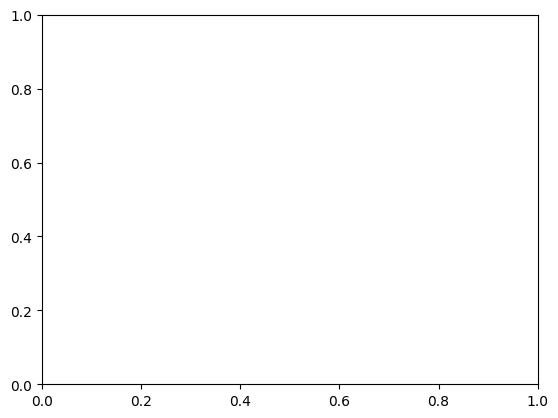

In [74]:
X = np.linspace(0, Time_1)
x2 = np.arange(0, 249999)
Y = p1    

plt.plot(Time_1, pro_avg, label = 'P1', linestyle='--')
#plt.plot(Time_2, pro2, label = 'P2', linestyle='-')

plt.show()
